In [1]:
%matplotlib notebook

import os
import time
import numpy as np
import matplotlib as mpl

from collections import OrderedDict
from importlib import reload
from matplotlib import pyplot as plt

from labtools import mplplots; reload(mplplots)
from labtools.mplplots.init_nb_plotting import *
from labtools.mplplots import tools as mpltools

import qcodes as qc
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_by_id
from qcodes.dataset.data_set import DataSet
from qcodes.sweep import sweep, nest, chain, szip, getter, setter
from qcodes.sweep.sweep import ParameterSweep, Nest, ParameterWrapper, FunctionWrapper, FunctionSweep, getter
from pytopo.qctools import instruments as instools

from v2_dataset_tools.experiments import do_experiment, get_results_from_db_path

In [2]:
from scipy import constants
from scipy.interpolate import interp1d
from scipy.optimize import fmin
from scipy.integrate import cumtrapz

In [3]:
from qcodes.dataset.sqlite_base import transaction, one

def get_timestamp(run_id):
    DB = qc.config["core"]["db_location"]
    
    d = DataSet(DB)
    sql = """
    SELECT run_timestamp
    FROM
      runs
    WHERE
      run_id= ?
    """
    c = transaction(d.conn, sql, run_id)
    run_timestamp = one(c, 'run_timestamp')
    return run_timestamp

def timestamp_to_fmt(ts, fmt):
    return time.strftime(fmt, time.gmtime(ts))

def img_basepath(run_id):
    ts = get_timestamp(run_id)
    return timestamp_to_fmt(ts, qc.config['user']['img_dir'] + str(run_id).zfill(4) + '_')

def ds_title(run_id):
    return "{} #{}".format(os.path.abspath(qc.config['core']['db_location']), run_id)

qc.config['user']['img_dir'] = "d:/data/images/%Y-%m/%Y-%m-%d/"
qc.config.save_to_cwd()

In [4]:
def process_data(bias, V_ratio=10e-3):    
    bias    = bias * (V_ratio*1e-3)
    return bias

def fit_resistance(i, v, ilim=None, vlim=None):  
    if ilim is not None:
        fltr = (i>ilim[0]) & (i<ilim[1])
    elif vlim is not None:
        fltr = (v>vlim[0]) & (v<vlim[1])
    else:
        fltr = slice(None, None, None)
        
    i2 = i[fltr]
    v2 = v[fltr]
    
    p = np.polyfit(v2, i2,  1)
    i_fit = np.polyval(p, v2)
    r_fit = 1./p[0]
    
    return v2, i_fit, r_fit

<IPython.core.display.Javascript object>


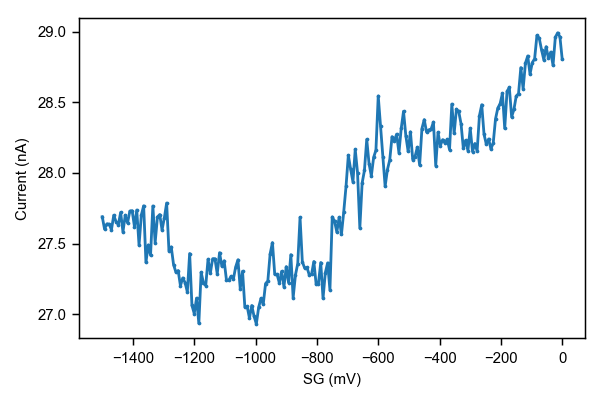

In [53]:
ds_fw = qc.load_by_id(115)
dataid_fw = ds_fw.run_id

ds_bw = qc.load_by_id(110)
dataid_bw = ds_bw.run_id

t1_fw = np.array(ds_fw.get_values('ivvi_dac8'))[:,0]
t1_bw = np.array(ds_bw.get_values('ivvi_dac6'))[:,0]
i_fw  = np.array(ds_fw.get_values('current'))[:,0]
i_bw  = np.array(ds_bw.get_values('current'))[:,0]

fig, ax = plt.subplots(1, 1)
ax.plot(t1_fw, i_fw*1e9, 'o-', ms=1, label = "forward")
# ax.plot(t1_bw, i_bw*1e9, 'o-', ms=1, label = "backward")
ax.set_xlabel('SG (mV)')
ax.set_ylabel('Current (nA)')
fig.tight_layout()

# basepath = img_basepath(dataid)
# if not os.path.exists(os.path.split(basepath)[0]):
#     os.makedirs(os.path.split(basepath)[0])
# fig.savefig(basepath + 'Cq030307M_T1_pinchoff.png', dpi=300)

<IPython.core.display.Javascript object>


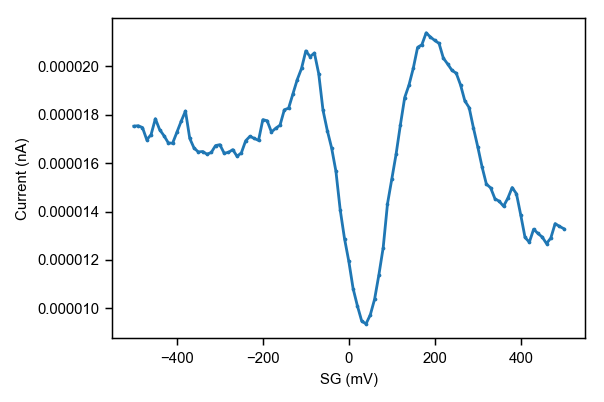

In [56]:
ds = qc.load_by_id(131)
dataid_fw = ds.run_id

b     = np.array(ds.get_values('ivvi_dac1'))[:,0]
i     = np.array(ds.get_values('current'))[:,0]
l1x   = np.array(ds.get_values('L1X'))[:,0]
l1y   = np.array(ds.get_values('L1Y'))[:,0]

dIdV = ((l1x**2+l1y**2)**.5/(2.5*1e-6))


fig, ax = plt.subplots(1, 1)
ax.plot(b, dIdV, 'o-', ms=1, label = "forward")
# ax.plot(t1_bw, i_bw*1e9, 'o-', ms=1, label = "backward")
ax.set_xlabel('SG (mV)')
ax.set_ylabel('Current (nA)')
fig.tight_layout()

# basepath = img_basepath(dataid)
# if not os.path.exists(os.path.split(basepath)[0]):
#     os.makedirs(os.path.split(basepath)[0])
# fig.savefig(basepath + 'Cq030307M_T1_pinchoff.png', dpi=300)